<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/linalg_eig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset -f

## 固有値計算

アーベル・ルフィニの定理より5次以上の代数方程式には公式が存在しない。よって5x5行列の特性方程式は直接的に解けないため、反復法を使用する。

### べき乗法

べき乗法では対象の行列$A$のべき乗で最大固有値とその固有ベクトルを求める。

$A(A^{\infty}\vec{x})=\lambda(A^{\infty}\vec{x})$となることを利用する。

ランダム行列を作成

A=


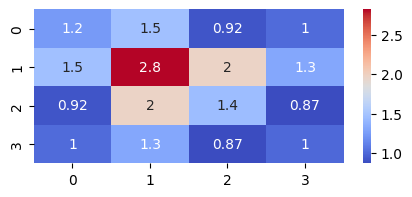

In [117]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N = 4
A = np.random.rand(N, N)
# 固有値正を保証
A = A @ A.T
print("A=")
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()

In [118]:
eps=1e-6
max_iter=100

x = (_ := np.random.rand(N)) / np.linalg.norm(_)
lambda_ = 0
for i in range(max_iter):
  # 反復毎に最大固有値の固有ベクトル成分が大きくなる
  v = A @ x
  # 最終的に(x,Ax)=(x,λx)=λとなるはず
  lambda_ = np.dot(x, v)
  x = v / np.linalg.norm(v)
  if np.dot(v, v) - lambda_ ** 2 < eps:
    break

print(f"{i=}")
print(f"{lambda_=:.3}")
print(f"{x=}")
print(f"{A@x-lambda_*x=}")

i=4
lambda_=5.73
x=array([0.405, 0.69 , 0.477, 0.365])
A@x-lambda_*x=array([-2.578e-05,  1.394e-05,  1.759e-05, -2.064e-05])


### QR 分解

最も基本的な QR 分解はグラム・シュミットの直交化を利用。

対象の正則行列$A$の各列を一次独立なベクトルとみなして直交化。
直交化したベクトルを並べたものを行列$Q$として、$A=QR$となるように行列$R$を構成。

Q=


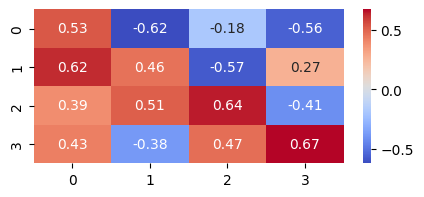

R=


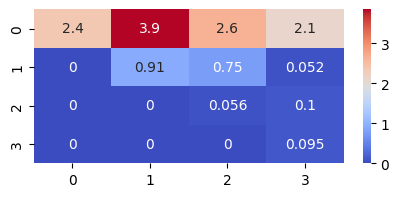

A-QR=


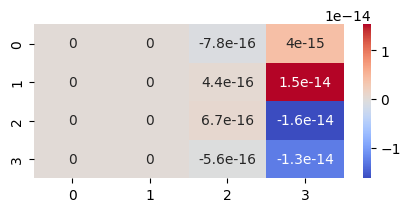

In [119]:
def QR_decomp(A_):
  A = A_.copy()
  N = len(A)
  Q = np.zeros_like(A)
  R = np.zeros_like(A)

  for i in range(N):
    # グラム・シュミットの直交化 -> Q を計算
    u = A[:, i]
    for j in range(i):
      u -= np.dot(A[:, i], Q[:, j]) * Q[:, j]
    Q[:, i] = u / np.linalg.norm(u)

    # 上三角行列 R を計算
    for j in range(i, N):
      if i == j:
        vec = A[:, j]
        for k in range(i):
          vec -= np.dot(A[:, j], Q[:, k]) * Q[:, k]
        R[i, j] = np.linalg.norm(vec)
      else:
        R[i, j] = np.dot(A[:, j], Q[:, i])

  return Q, R

Q, R = QR_decomp(A)

print("Q=")
sns.heatmap(Q, annot=True, cmap='coolwarm')
plt.show()

print("R=")
sns.heatmap(R, annot=True, cmap='coolwarm')
plt.show()

print("A-QR=")
sns.heatmap(A-Q@R, annot=True, cmap='coolwarm')
plt.show()

QR 法は QR 分解を繰り返して固有値を対角成分に持つ行列を作成。

$A_k=Q_kR_k, A_{k+1}=R_kQ_k=Q_k^{-1}AQ_k=Q_k^TAQ_k$を繰り返して、直交変換。

evalues=array([5.733, 0.634, 0.115, 0.027])
evectors=array([[-0.405, -0.646, -0.544,  0.35 ],
       [-0.69 ,  0.349, -0.27 , -0.574],
       [-0.477,  0.44 ,  0.286,  0.705],
       [-0.365, -0.517,  0.741, -0.225]])
A_=


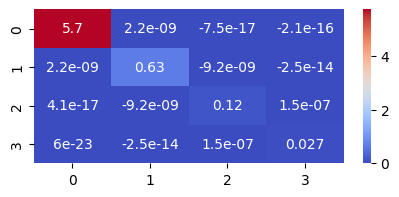

residuals=[-3.553e-15  1.110e-16 -2.396e-13  2.393e-13]


In [120]:
evalues, evectors = np.linalg.eigh(A)
# 固有値が大きい順に並べる
idx = evalues.argsort()[::-1]
evalues = evalues[idx]
evectors = evectors[:, idx]
print(f"{evalues=}")
print(f"{evectors=}")

def QR_iteration(A):
  A_ = A.copy()
  # TODO: 終了条件を追加
  for _ in range(10):
    Q, R = QR_decomp(A_)
    A_ = Q.T @ A_ @ Q
  return A_

A = QR_iteration(A)
print("A_=")
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()
print(f"residuals={np.diag(A)-evalues}")

### 逆反復法

## 固有値計算の高速化

ランダム行列を再生成

In [ ]:
N = 4
A = np.random.rand(N, N)
# 固有値正を保証
A = A @ A.T
print("A=")
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()

### ハウスホルダー変換

対角成分より2以上左の成分が0となっている行列をヘッセンベルグ行列という。
QR 分解の前処理としてハウスホルダー変換と呼ばれる直交・鏡映変換で、
対象行列をヘッセンベルグ行列へ変換する。

P=


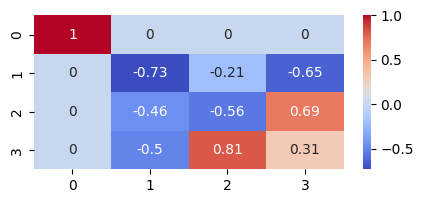

A=


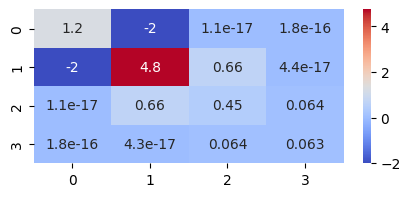

In [121]:
def house(b):
  e = np.zeros_like(b)
  e[0] = 1
  # 桁落ち対策で異符号に
  s = -np.sign(b[0]) * np.linalg.norm(b)
  u = (_ := b - s * e) / np.linalg.norm(_)
  P = np.eye(len(b)) - 2 * np.outer(u, u)
  return P

P = np.eye(N)
for k in range(N - 2):
  x = A[k+1:, k]
  # ハウスホルダー変換
  Pk = np.eye(N)
  Pk[k+1:, k+1:] = house(x)

  A = Pk @ A @ Pk
  P = P @ Pk

print("P=")
sns.heatmap(P, annot=True, cmap='coolwarm')
plt.show()

print("A=")
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()

evalues=array([5.733, 0.634, 0.115, 0.027])
evectors=array([[-0.405,  0.646,  0.544,  0.35 ],
       [ 0.907,  0.196,  0.306,  0.212],
       [ 0.114,  0.733, -0.493, -0.454],
       [ 0.001,  0.082, -0.606,  0.791]])
A_=


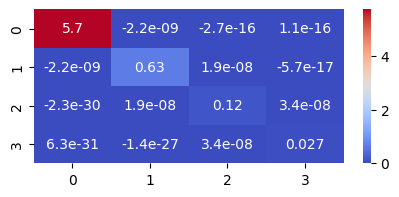

residuals=[ 8.882e-16 -1.110e-15 -1.282e-14  1.278e-14]


In [122]:
evalues, evectors = np.linalg.eigh(A)
# 固有値が大きい順に並べる
idx = evalues.argsort()[::-1]
evalues = evalues[idx]
evectors = evectors[:, idx]
print(f"{evalues=}")
print(f"{evectors=}")

def QR_iteration(A):
  A_ = A.copy()
  # TODO: 終了条件を追加
  for _ in range(10):
    Q, R = QR_decomp(A_)
    A_ = Q.T @ A_ @ Q
  return A_

A_ = QR_iteration(A)
print("A_=")
sns.heatmap(A_, annot=True, cmap='coolwarm')
plt.show()
print(f"residuals={np.diag(A_)-evalues}")

### ギブンス回転

### 原点シフト

## 特異値分解

### 右特異ベクトル

行列 $A$ に対して行列 $A^TA$ を考える。
明らかに $(A^TA)^T=A^TA$ なので対称行列。
[スペクトル定理](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%83%9A%E3%82%AF%E3%83%88%E3%83%AB%E5%AE%9A%E7%90%86)より固有値は常に実数である。

また行列 $A$ の非負定値の条件は任意の $\vec{x}\neq\vec{0}$ に対して $\vec{x}^TA\vec{x}\geq0$。
よって任意の $A, \vec{x}\neq\vec{0}$ に対して $\vec{x}^T(A^TA)\vec{x}=||A\vec{x}||^2\geq0$。
これより固有値は常に非負である。そのため固有値の平方根も常に実数である。

これは $AA^T$ でも同様に成立。

実際に確かめるために乱数生成の行列でこれを計算。

<Axes: >

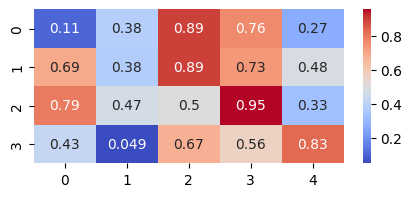

In [123]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N, M = 4, 5
A = np.random.rand(N, M)
sns.heatmap(A, annot=True, cmap='coolwarm')

$A^TA$ は対称行列

<Axes: >

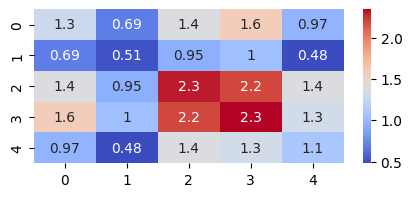

In [124]:
ATA = A.T @ A
sns.heatmap(ATA, annot=True, cmap='coolwarm')

固有値はすべて実数で非負（数値誤差に注意）

w_right=array([ 6.854e+00,  3.526e-01,  2.978e-01,  4.392e-02, -3.994e-16])


<Axes: >

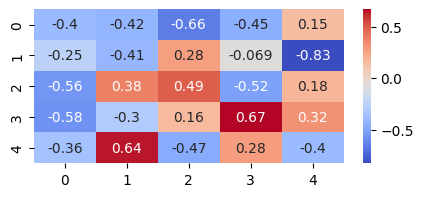

In [125]:
import numpy.linalg as la

w_right, V = la.eigh(ATA)
# 固有値が大きい順
w_right, V = w_right[::-1], V[:, ::-1]
print(f"{w_right=}")
sns.heatmap(V, annot=True, cmap='coolwarm')

固有ベクトルは$V$の各列が対応。
検算で $\vec{v}^T(A^TA)\vec{v}-w$ を計算。

<Axes: >

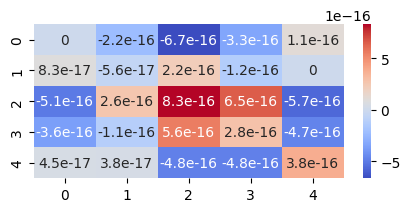

In [126]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

$V$ 行列は直交行列(ユニタリー行列)で[右特異ベクトル](https://manabitimes.jp/math/1280#5)

<Axes: >

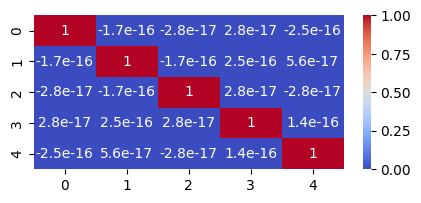

In [127]:
import seaborn as sns

# 検算。ユニタリなら単位行列に近くなる。
sns.heatmap(V.T @ V, annot=True, cmap='coolwarm')

### 左特異ベクトル

同様に $AA^T$ について計算し左特異ベクトル$U$を求める

w_left=array([6.854, 0.353, 0.298, 0.044])


<Axes: >

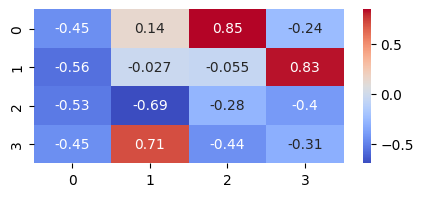

In [128]:
AAT = A @ A.T
w_left, U = la.eigh(AAT)
# 固有値が大きい順
w_left, U = w_left[::-1], U[:, ::-1]

print(f"{w_left=}")
sns.heatmap(U, annot=True, cmap='coolwarm')

左特異ベクトルを検算

<Axes: >

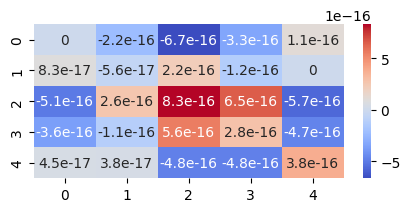

In [129]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

<Axes: >

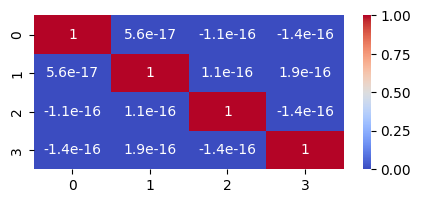

In [130]:
sns.heatmap(U.T @ U, annot=True, cmap='coolwarm')

### 特異値分解

数値誤差の対策。ほぼ0は0とする。

In [131]:
w_right = np.array([w if abs(w) > 1e-10 else 0 for w in w_right])
w_left = np.array([w if abs(w) > 1e-10 else 0 for w in w_left])
print(f"{w_right=}")
print(f"{w_left=}")

w_right=array([6.854, 0.353, 0.298, 0.044, 0.   ])
w_left=array([6.854, 0.353, 0.298, 0.044])


$A^TA, AA^T$ の固有値の平方根は特異値

In [132]:
sigma_right = np.sqrt(w_right)
sigma_left = np.sqrt(w_left)
print(f"{sigma_right=}")
print(f"{sigma_left=}")

sigma_right=array([2.618, 0.594, 0.546, 0.21 , 0.   ])
sigma_left=array([2.618, 0.594, 0.546, 0.21 ])


特異値による行列 $\Sigma$ を作成

In [133]:
Sigma = np.zeros_like(A)
sigma = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma[:len(sigma), :len(sigma)] = np.diag(sigma)
print(f"{Sigma=}")

Sigma=array([[2.618, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.594, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.546, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.21 , 0.   ]])


固有ベクトルには符号の不定性があるためそのままでは$A=U\Sigma V^T$を満たすとは限らない。

$\Sigma$の成分は非負なので$(AV)_i=\lambda_iU_i, \lambda_i\geq0$。
そこでこの[条件を満たすように符号の反転をする](
https://math.stackexchange.com/questions/4844816/discrepancies-in-custom-svd-implementation-compared-to-np-linalg-svd-sign-issu)。

<Axes: >

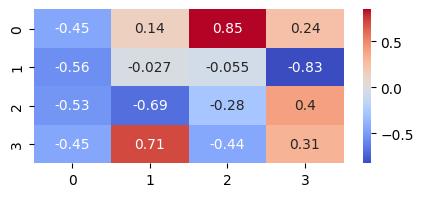

In [134]:
U = np.array([np.sign(np.dot(A @ V[:, idx], U[:, idx])) * U[:, idx]
    for idx in range(U.shape[1])]).T
sns.heatmap(U, annot=True, cmap='coolwarm')

[特異値分解](https://manabitimes.jp/math/1280#5) $A=U\Sigma V^T$ の検算。

<Axes: >

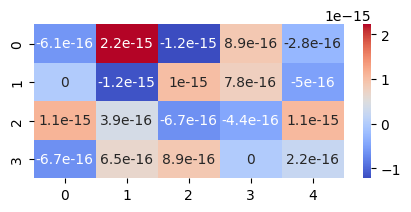

In [135]:
residuals = A - (U @ Sigma @ V.T)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

numpy の標準機能でも特異値分解。

In [136]:
U2, sigma2, V2h = la.svd(A)
print(sigma2)

[2.618 0.594 0.546 0.21 ]


特異ベクトルは符号の不定性があるため、対角化から求めた結果と一致するとは限らない。

sigma2-sigma=array([1.332e-15, 3.331e-16, 5.551e-16, 2.220e-16])


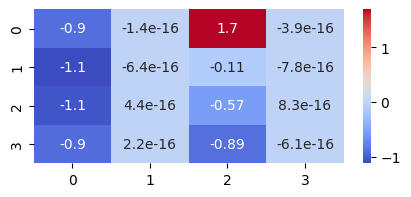

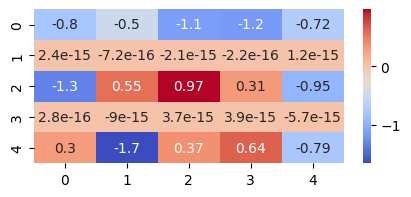

In [137]:
import matplotlib.pyplot as plt

print(f"{sigma2-sigma=}")
sns.heatmap(U-U2, annot=True, cmap='coolwarm')
plt.show()
sns.heatmap(V.T - V2h, annot=True, cmap='coolwarm')
plt.show()

特異分解$A=U\Sigma V^T$はきちんと満たす。

<Axes: >

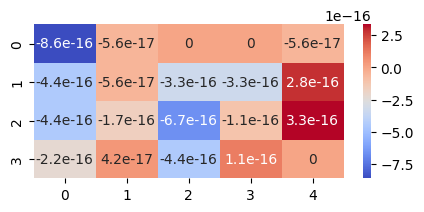

In [138]:
Sigma2 = np.zeros_like(A)
sigma2 = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma2[:len(sigma2), :len(sigma2)] = np.diag(sigma2)
residuals = A - (U2 @ Sigma2 @ V2h)
sns.heatmap(residuals, annot=True, cmap='coolwarm')